In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [10]:
import simfin as sf

sf.set_api_key('6fdb2dc3-d138-4b2c-9bc9-57041a206c28')
sf.set_data_dir('simfin_data')

# Long-Term Stock Forecasting

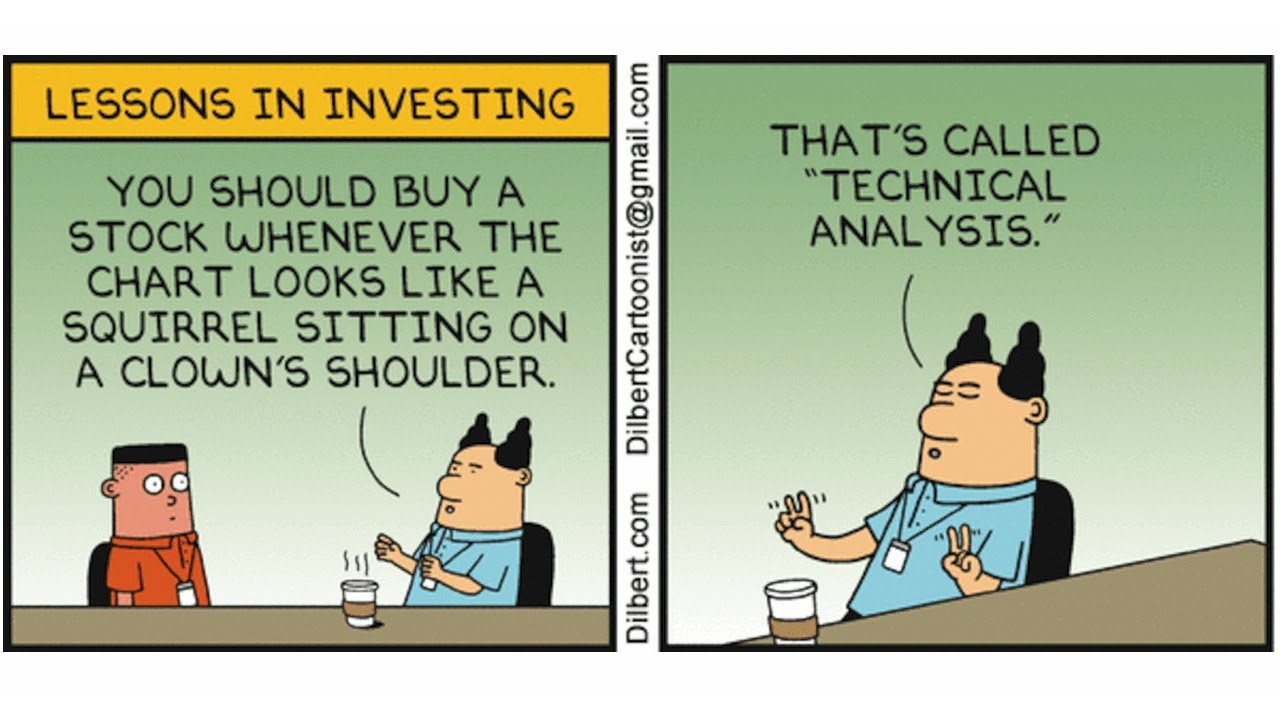

**Урок по инвестированию** 

*покупай акцию всякий раз, когда график выглядит как белка, сидящая на плече клоуна. Это называется технический анализ.*


Этот ноутбук посвящен изучению вопроса предсказания дохода от акций в долгосрочной перспективе.

## Из далека

### Вспомнить всё

- **Акция** — ценная бумага, которая со временем как то меняет свою стоимость.
- **Портфель** — набор акций.
- **Стоимость ценной бумаги** — случайная величина $X_t: \Omega \rightarrow \mathbb{R}$
- **Доходность** — случайная величина $R_t = \frac{X_{\text{t + 1}} - X_{\text{t}}}{X_{\text{t}}}$
- Доход == Выручка, однако Доход - не Прибыль 

Обратите внимание на то, что доходность у нас считается относительно следующего дня! То есть $R_t$ в каком то смысле показывает прирост(или убыток), который произойдет в следующий день:

Если $R_t > 1$, то завтра акция будет стоить дороже.

У этого есть технические причины, о которых можно почитать в разделе дополнительных материалов.

Прошлый доклад с тервера был посвящён составлению портфеля, оптимизации и диверсификации. В нем мы постарались ответить на вопрос:
- Как мне вложиться в имеющийся набор акций, чтобы в будущем получить наибольшую доходность

Мы тогда дали решение и строгое математическое обоснование. Однако в конце доклада был поставлен вопрос: Как следует определять будущие данные об акциях?

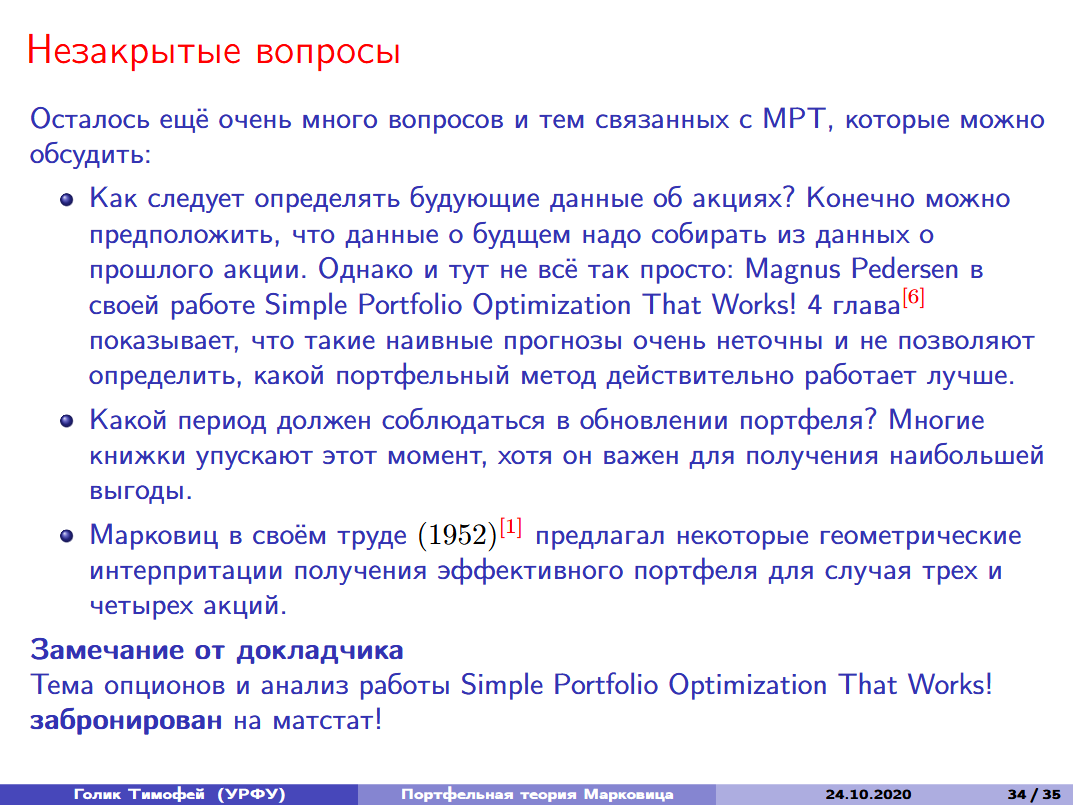

Действительно: мы конечно можем протестировать нашу модель на каких то уже известных нам данных, но как собрать портфель на практике?


### Наивное предсказание

Покажем, что предсказывать будущую стоимость акции, основываясь на прошлом - плохая идея. Для этого будем использовать данные от `simfin`.

In [6]:
# Интерфейс для работы с рынком USA
hub = sf.StockHub(market='us', refresh_days_shareprices=100)

# Скачаем данные об акциях за каждый день
df_daily_prices = hub.load_shareprices(variant='daily')

Dataset "us-shareprices-daily" on disk (24 days old).
- Loading from disk ... 

d:\MISHA\LTSF\.venvLTSF\Lib\site-packages\simfin\load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,


Done!


Мы например можем запросить данные об акциях Apple(`AAPL`)

In [7]:
df_daily_prices.loc["AAPL"].head(5)

,SimFinId,Open,High,Low,Close,Adj. Close,Volume,Dividend,Shares Outstanding
Date,,,,,,,,,
2019-06-06,111052,45.77,46.37,45.54,46.30,44.54,90105244,NaN,1.840430e+10
2019-06-07,111052,46.63,47.98,46.44,47.54,45.73,122737572,NaN,1.840430e+10
2019-06-10,111052,47.95,48.84,47.91,48.15,46.31,104883404,NaN,1.840430e+10
2019-06-11,111052,48.72,49.00,48.40,48.70,46.85,107731528,NaN,1.840430e+10
2019-06-12,111052,48.49,48.99,48.35,48.55,46.70,73012756,NaN,1.840430e+10


Это конечно круто, но использовать в сыром виде данные об акциях не очень удобно:
- Для одно временного промежутка данные об акциях могут отсутствовать, из-за чего будем видеть `NAN`
- Много лишнего
- Нет значения доходности

Давайте исправим этот момент. Пока просто получим значение доходности для каждой акции обработав `NAN`-ы и остальные тонкие моменты 

In [8]:
# В этом скрипте происходит вся магия по обработке данных
import data_loader  

daily_returns = data_loader.prepare_data(df_daily_prices)

d:\MISHA\LTSF\data_loader.py:33: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change(periods=1) + 1.0
d:\MISHA\LTSF\.venvLTSF\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [6]:
daily_returns

Ticker,A,AA,AAL,AAON,AAP,AAPL,AAWW,AB,ABBV,ABCB,...,ZGNX,ZION,ZLAB,ZM,ZNGA,ZNTL,ZS,ZTO,ZTS,ZUO
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-06,1.005130,0.993753,1.017958,1.013813,1.002887,1.026718,1.049750,0.995338,1.004723,0.991412,...,1.008792,0.986535,0.997850,1.184061,0.995378,1.000000,1.043965,1.016763,1.010678,0.999314
2019-06-07,1.011108,1.006770,0.994773,0.995564,0.988196,1.012683,1.010532,1.009953,0.993788,1.016726,...,1.019995,1.004457,1.021544,1.084530,0.975232,1.000000,1.018673,1.021560,1.001523,1.013736
2019-06-10,0.997179,1.004323,0.994089,0.986314,0.991260,1.011661,1.028040,0.992464,1.015881,1.021152,...,0.986177,1.013311,1.044288,0.930098,0.995238,1.000000,0.985829,1.017381,0.999430,0.960027
2019-06-11,1.002829,0.976566,1.016848,0.996773,0.989273,0.996798,0.979483,1.028621,1.005155,0.993959,...,1.003313,0.994253,1.012790,1.083272,0.987241,1.000000,1.017671,1.003051,1.011601,1.056457
2019-06-12,1.000148,1.029873,1.064003,1.024280,1.000446,0.999786,1.037457,1.033504,1.004798,1.010130,...,1.008890,1.012662,1.036889,0.982291,1.006462,1.000000,1.033044,1.012165,0.987310,0.997996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,1.014067,1.023073,0.999278,0.862602,1.018589,1.059807,1.000000,1.018146,1.018501,1.023285,...,1.000000,1.021045,0.979506,0.983925,1.000000,1.054005,1.004196,0.993768,0.999032,1.031730
2024-05-03,1.008309,1.014851,1.057762,0.971959,0.967928,0.990905,1.000000,0.999028,0.993544,0.998578,...,1.000000,1.001895,1.040615,1.000000,1.000000,1.000854,1.005816,0.996141,0.993281,1.030754
2024-05-06,1.004657,1.006775,0.972696,1.029640,1.008734,1.003760,1.000000,0.985728,0.998853,0.995117,...,1.000000,1.002601,0.986399,1.005176,1.000000,1.050341,0.992983,0.960291,1.015052,1.011550


Теперь займемся анализом реальных данных: изучим как изменялось скользящие среднее, стандартное квадратичное отклонение, а так же рассмотрим корреляцию между другими акциями

Выберем, например, акции Apple(`AAPL`) и Amazon(`AMZN`)

In [7]:
windows = [20, 60, 250]
tickers = ['AAPL', 'AMZN']

rets = daily_returns[tickers]

Теперь для каждого окна посчитаем статистики, а затем объединим результат

In [8]:
list_mean = []
list_std = []
list_corr = []

for window in windows:
    # stack ещё по дефолту отбрасывает Nan-ы у первых окон. Поэтому нам не надо их самими убирать
    mean = rets.rolling(window=window).mean().stack().rename(str(window) + ' Days')
    std = rets.rolling(window=window).std().stack().rename(str(window) + ' Days')
    corr = rets.rolling(window=window).corr().stack().rename(str(window) + ' Days')

    # Переименуем
    corr.index.rename(['Date', 'Ticker', 'Ticker2'], inplace=True)

    list_mean.append(mean)
    list_std.append(std)
    list_corr.append(corr)

# Представляем в виде фрэймов pandac
df_mean = pd.concat(list_mean, axis=1).dropna()
df_std = pd.concat(list_std, axis=1).dropna()
df_corr = pd.concat(list_corr, axis=1).dropna()

Посмотрим на то, что у нас получилось 

In [9]:
df_mean

20 Days   60 Days  250 Days
Date       Ticker                              
2020-06-02 AAPL    1.004623  1.004150  1.002617
           AMZN    1.003414  1.005774  1.001572
2020-06-03 AAPL    1.003681  1.002807  1.002476
           AMZN    1.002334  1.004810  1.001430
2020-06-04 AAPL    1.004582  1.003861  1.002539
...                     ...       ...       ...
2024-05-06 AMZN    1.000991  1.001426  1.002452
2024-05-07 AAPL    1.004477  0.999721  1.000308
           AMZN    1.000714  1.001560  1.002302
2024-05-08 AAPL    1.002813  1.000076  1.000343
           AMZN    1.000280  1.002051  1.002262

[1982 rows x 3 columns]

Осталось только отобразить эти данные. Конечно, сам процесс отрисовки имеет свои тонкости, однако это не столь важно для нашего повествования.

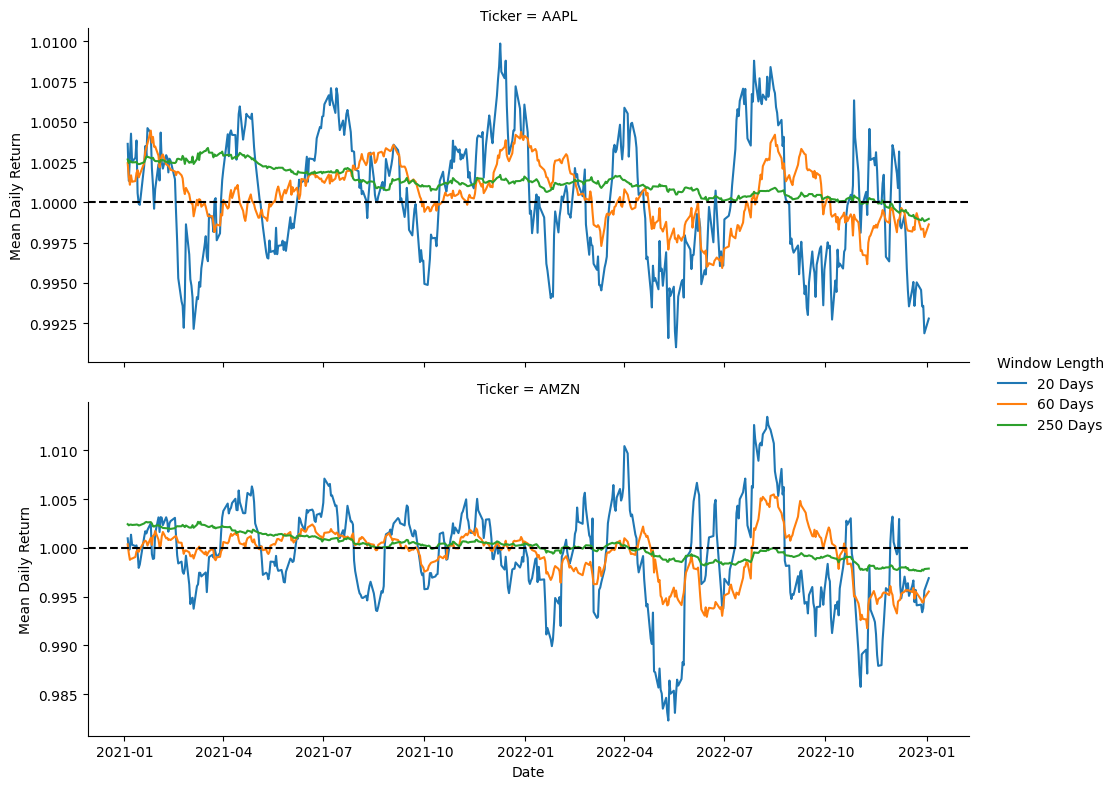

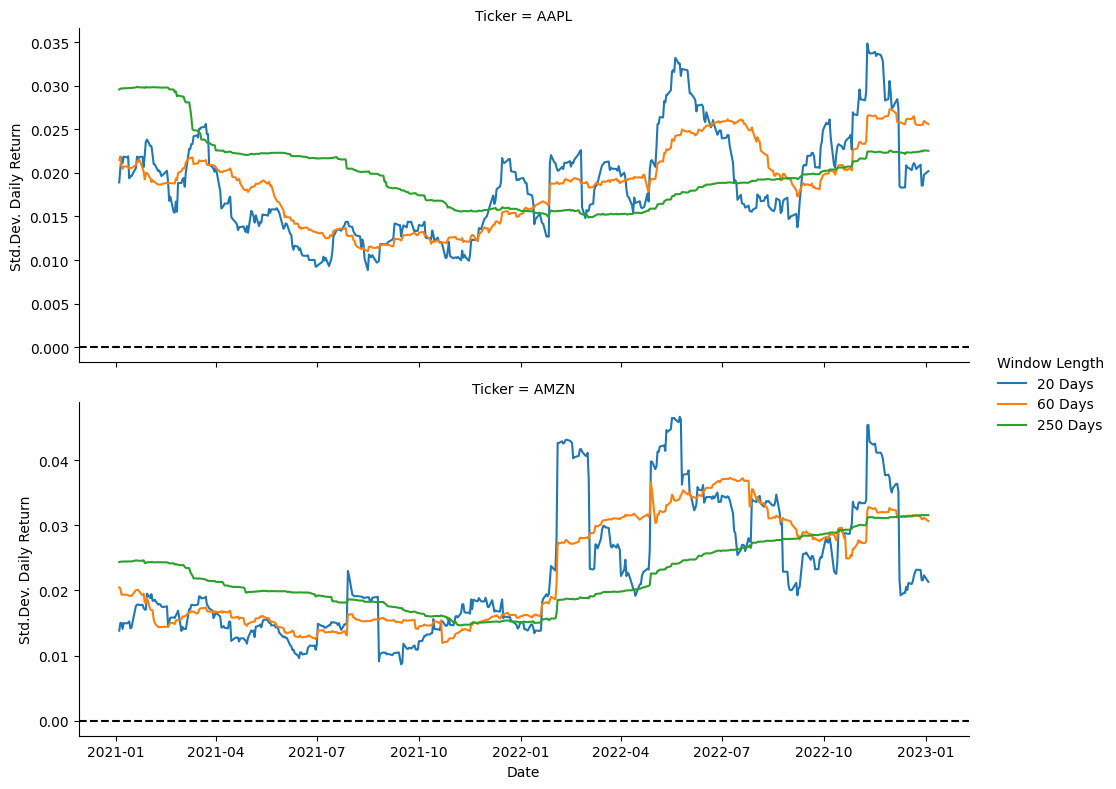

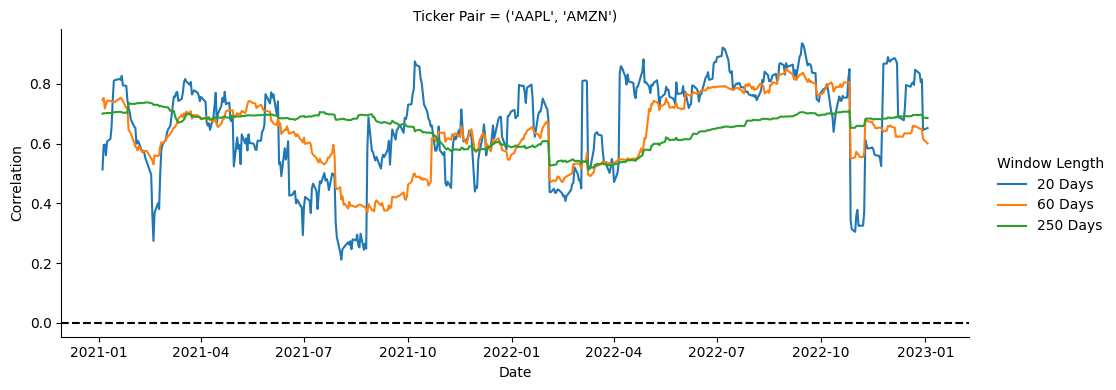

In [10]:
import plot_drawer

def get_from_range(df, start, end):
    df = df.copy()
    df.index = df.index.set_levels(pd.to_datetime(df.index.levels[0]), level=0)
    return df.loc[start:end]

# опционально. Можно рисовать график для всего доступного промежутка
if True:
    start_year = '2021'
    end_year = '2023'
    df_mean = get_from_range(df_mean, start_year, end_year)
    df_std = get_from_range(df_std, start_year, end_year)
    df_corr = get_from_range(df_corr, start_year, end_year)

plot_drawer.draw_return_statatistics_plots(df_mean, df_std, df_corr, tickers, windows)

Из графиков сразу видно, что невозможно делать предсказания хоть с какой-то точностью
- Для окна в 20 дней доходность имеет высокую волатильность(сильно изменчива со временем)
- По мере увеличения окна статистики начинают вести себя менее скачкообразно
- Окно в 250 дней выглядит более предсказуемым
- Хоть и для окна в 250 дней мы можем наблюдать какой-то тренд, но даже так статистика в некоторых моментах отклоняется от него.

#### А что если использовать статистику для окна в 1 год для предсказания будущего в 1 месяц?

Пользоваться таким допущением нельзя! **Статистика подсчитанная за период в 1 год не содержит в себе информации об промежутках меньших 1 года**. Это видно по самим графикам. 
Да и не трудно придумать простой пример.

Пусть у нас доходность по месяцам представляла следующее: `[1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 0.85]`

Тогда годовая доходность будет составлять

In [11]:
(11 * 1.02 + 0.85) / 12

1.0058333333333334

Но считать, что в следующий месяц стоимость акции возрастет на `0.5%` глупо.

## Long-Term Stock Forecasting 

### Теоретическая модель

Мы можем получить доход от акции двумя способами:
- Дивденды — выплаты, которые даются владельцам акции соразмерно с их долей владением
- Изменение в стоимости — вчера дешевле, завтра подороже

Сделаем следующее предположение:

Если акция даёт нам дивиденды, то полученные средства мы сразу вкладываем на покупку ещё акций этой же компании.

Тогда общий доход (обозначим его за $\mathbf{Total\ Return}_{t}$) в момент времени $t$

$$
\text{Total\ Return}_{t} = \text{Shares}_t \cdot \text{Share} \ \text{Price}_t
$$

Где
- $\text{Share} \ \text{Price}_t$ - цена акции
- $\text{Share}$ - кол-во акций.

Таким образом $\text{Total\ Return}_{t}$ учитывает теперь доходы и с дивидендов(так как они будут влиять на количество акций, которыми мы владеем), и с изменением цен ($\text{Share} \ \text{Price}_t$).

Теперь ввёдем такое понятие, как годовая доходность в течение нескольких лет (Его обозначим как $\mathbf{Ann\ Return}_t$).

$$
\text{Ann\ Return}_t = \left( \frac{\text{Total\ Return}_{t+\text{Years}}}{\text{Total\ Return}_t} \right)^{1/\text{Years}} - 1.
$$

И теперь, если мы вспомним чему равно $\text{Total\ Return}_{t}$, получим следующее:

$$
\text{Ann\ Return}_t = \left( \frac{\text{Shares}_{t+\text{Years}} \cdot \text{Share} \ \text{Price}_{t+\text{Years}}}{\text{Shares}_t \cdot \text{Share} \ \text{Price}_t} \right)^{1/\text{Years}} - 1
$$

#### Мультипликаторы

Мультипликаторы в инвестициях — это показатели, которые позволяют сравнивать компании друг с другом без учёта их масштаба и других факторов.

Перечислим некоторые из них:
- $P/E\ (\text{Price\ to\ Earnings})$ — отношение капитализации компании к чистой прибыли за год.
- $\text{P/Sales}\ (\text{Price\ to\ Sales})$ — отношение капитализации к годовой выручке.
- $PEG\ (\text{Price\ Earnings\ Growth})$ — отношение Р/Е к прогнозируемому росту прибыли или средним темпам прироста прибыли за 5 лет.

Более формально $P/\text{Sales}_t$ определяется следующим образом

$$
P/\text{Sales}_t = \frac{\text{Share\ Price}_t \cdot \text{Total\ Assets}_t}{\text{Sales\ Per\ Share}_t \cdot \text{Total\ Assets}_t} = \frac{\text{Share\ Price}_t}{\text{Sales\ Per\ Share}_t},
$$

где
- $\text{Share} \ \text{Price}_t$ - цена акции 
- $\text{Total\ Assets}_t$ - кол-во акций
- $\text{Sales\ Per\ Share}_t$ - часть дохода, которая приходится на каждую акцию. Если к примеру у компании $500,000$ акций, а доход $\$1,000,000$, тогда

$$
\text{Sales\ Per\ Share} = \frac{1,000,000}{500,000} = 2.
$$

То есть на каждую акцию приходится $2\$$ выручки. 

$\text{P/Sales}$ показывает насколько сильно акция переоценена на рынке. Если $\text{P/Sales} > 5$, то акции переоценены, её стоимость не пропорциональна её доходности. Такое значение свойственно для технологических и инновационных компаний, в которые верит рынок. И напротив, если $\text{P/Sales} < 1$, то акции недооценены: компания имеет значительную выручку по сравнению с её рыночной стоимостью.

Теперь запишем стоимость акции как

$$
\text{Share\ Price}_t = \text{P/Sales}_t \cdot \text{Sales\ Per\ Share}_t
$$

и подставить в формулу годовой доходности

$$
\text{Ann Return}_t = \left( 
\overset{\textcolor{red}{\text{Reinvest Dividends}}}{\frac{\text{Shares}_{t+\text{Years}}}{\text{Shares}_t}} \cdot
\overset{\textcolor{red}{\text{Revaluation}}}{\frac{P/\text{Sales}_{t+\text{Years}}}{P/\text{Sales}_t}} \cdot
\overset{\textcolor{red}{\text{Sales Growth}}}{\frac{\text{Sales Per Share}_{t+\text{Years}}}{\text{Sales Per Share}_t}} 
\right)^{1/Years} - 1.
$$

Мы получили формулу для годовой доходности, которую можно разбить на 3 компоненты:
- $\text{Reinvest\ Dividends}$ — **Реинвистируемые Дивиденды** — ожидаемый рост доход от дивидентов, которые мы сразу вложим в акцию
- $\text{Revaluation}$ — **Ревальвация** — ожидаемый рост значения мультипликатора
- $\text{Sales\ Growth}$ — **Рост продаж/доходности** — ожидаемый рост дохода компании

Заметим, что эта формула точно отвечает на вопрос о годовой доходности акции спустя годы, если мы знаем точные значения трех параметров. Если мы например уверены, что какое-то из 3 параметров будет иметь определённое значение в будущем, то мы можем его подставить и упростить дальнейший анализ.


### Прогнозирование среднего дохода

Конечно мы не знаем будущего, поэтому не можем сказать точные значения трех параметров: $Reinvest\ Dividends$, $Revaluation$ и $Sales\ Growth$. Поэтому лучшее что мы можем сделать — найти матожидание доходности и стандартное квадратичное отклонение, чтобы понимать, как сильно отстраняется настоящее значение от среднего.

Немного напомним об обозначениях:
- $\text{P/Sales}$ — отношение капитализации к годовой выручке.
- $\text{Sales\ Per\ Share}_t$ - часть дохода, которая приходится на каждую акцию.
- $\text{Shares}$ - число акций компании
- $\text{Ann\ Return}_t$ - годовая доходность в течении нескольких лет

Запишем матожидание от $Ann\ Return_t$:

$$
E[\text{Ann\ Return}_t] = E\left[ \left( \frac{\text{Shares}_{t+\text{Years}}}{\text{Shares}_t} \cdot \frac{\text{P/Sales}_{t+Years}}{\text{P/Sales}_t} \cdot \frac{\text{Sales\ Per\ Share}_{t+\text{Years}}}{\text{Sales\ Per\ Share}_t} \right)^{1/\text{Years}} - 1 \right]
$$

Из-за того, что $\text{P/Sales}_t$ нам известна(константа в момент времени $t$), мы можем по свойства матожидания её извлечь

$$
E[\text{Ann\ Return}_t] = \dfrac{E\left[ \left( \dfrac{\text{Shares}_{t+\text{Years}}}{\text{Shares}_t} \cdot \text{P/Sales}_{t+\text{Years}} \cdot \dfrac{\text{Sales\ Per\ Share}_{t+\text{Years}}}{\text{Sales\ Per\ Share}_t} \right)^{1/\text{Years}}\right]}{\text{P/Sales}_t^{1/\text{Years}}} - 1 
$$

А теперь сделаем допущение, предположив что 3 компоненты не зависят друг от друга. Да это неправильно суждение и мы скорее всего будем получать какие-то ошибки при расчётах. Но ведь попробовать никто не запрещает =)

$$
E[\text{Ann\ Return}_t] = \dfrac{E\left[ \left( \dfrac{\text{Shares}_{t+\text{Years}}}{\text{Shares}_t} \right)^{1/\text{Years}} \right]  \cdot E[\text{P/Sales}_{t+\text{Years}}^{1/\text{Years}}] \cdot E \left[ \left( \dfrac{\text{Sales\ Per\ Share}_{t+\text{Years}}}{\text{Sales\ Per\ Share}_t} \right)^{1/\text{Years}}\right]}{\text{P/Sales}_t^{1/\text{Years}}} - 1 
$$

На первый взгляд может показаться, что всё стало ещё запутаннее, но давайте разберёмся с каждой компонентой: 

- $\text{Shares}_{t+\text{Years}}$ — это будущее количество акций в нашем владении. Так как мы договорились реинвестировать деньги полученные с дивидендов в покупку ещё акций, то выражение  

$\left( \dfrac{\text{Shares}_{t+\text{Years}}}{\text{Shares}_t} \right)^{1/\text{Years}}$ приблизительно равно годовой доходности дивдидендов к стоимости акции в момент времени $t$, которая определяется следующей формулой:

$$
\text{Dividend Yield}_t + 1= \frac{\text{Dividend TTM}}{\text{Share Price}} + 1
$$

где $\mathbf{Dividend TTM}$ — дивиденды полученные за год с одной акции ($\mathbf{Trailing Tweleve Months}$). Приблизительно равно потому, что дивиденты выплачиваются по кварталам да и количество акций, которые мы купим после выплат дивидендов определяется стоимостью акций в этот день, а дни в формулах у нас немного разные. И всё же будем считать, что

$$
E\left[ \left( \dfrac{\text{Shares}_{t+\text{Years}}}{\text{Shares}_t} \right)^{1/\text{Years}} \right] \simeq E[\text{Dividend Yield} + 1]
$$


- $\text{P}/\text{Sales}_{t+\text{Years}}$ — можем попытаться вытащить экспоненты из под матожидания. Из-за неравенства Йенцена мы должны получить ещё небольшую ошибку:

$$
E[\text{P/Sales}^{1/\text{Years}}_{t+\text{Years}}] \simeq E[\text{P/Sales}_{t+\text{Years}}]^{1/\text{Years}}
$$

- $E \left[ \left( \dfrac{\text{Sales\ Per\ Share}_{t+\text{Years}}}{\text{Sales\ Per\ Share}_t} \right)^{1/\text{Years}}\right]$ — это ни что иное как средний годовой рост продаж на одну акцию. Если мы предположим, что рост продаж незивисит от одного года к другому, то мы можем переписать 

$$
E \left[ \left( \dfrac{\text{Sales\ Per\ Share}_{t+\text{Years}}}{\text{Sales\ Per\ Share}_t} \right)^{1/\text{Years}}\right] \simeq E[\text{Sales Per Share Growth Rate} + 1]
$$

Где $\text{Sales Per Share Growth Rate}$ - годовой темп роста выручки на одну акцию.

Объединяя, мы получаем одну из двух главных формул для нашей модели по предсказанию:

$$
E[\text{Ann Return}_t] = \frac{a}{\text{P/Sales}_t^{1/\text{Years}}} - 1,
$$

где параметр $a$ может быть подсчитан из трёх параметров, которые обсуждали ранее

$$
a \simeq E[\text{Dividend Yield} + 1] \cdot E[\text{P/Sales}^{1/\text{Years}}_{t+\text{Years}}] \cdot E[\text{Sales Per Share Growth Rate} + 1]
$$

### Прогнозирование $\text{std}$ доходности

Теперь найдем $\text{Std}[\text{Ann Return}_t]$.

$$
\text{Std}[\text{Ann Return}_t] = \text{Std}\left[ \left( \frac{\text{Shares}_{t+\text{Years}}}{\text{Shares}_t} \cdot \frac{\text{P/Sales}_{t+\text{Years}}}{\text{P/Sales}_t} \cdot \frac{\text{Sales\ Per\ Share}_{t+\text{Years}}}{\text{Sales\ Per\ Share}_t} \right)^{1/\text{Years}} - 1 \right]
$$

Пользуемся свойствами и тем, что $\text{P/Sales}_t$ нам известно:

$$
\text{Std}[\text{Ann Return}_t] = \dfrac{\text{Std}\left[ \left( \frac{\text{Shares}_{t+\text{Years}}}{\text{Shares}_t} \cdot \text{P/Sales}_{t+\text{Years}} \cdot \frac{\text{Sales\ Per\ Share}_{t+\text{Years}}}{\text{Sales\ Per\ Share}_t} \right)^{1/\text{Years}}\right]}{\text{P/Sales}_t^{1/\text{Years}}}
$$

Обозначим числитель $b$. Получаем вторую ключевую формулу для нашей модели:

$$
\text{Std}[\text{Ann Return}_t] = \dfrac{b}{\text{P/Sales}_t^{1/\text{Years}}},
$$

Где параметр $b$ может быть посчитан используя рассуждения из прошлого раздела для параметра $a$:

$$
b = \text{Std}\left[ \left( \frac{\text{Shares}_{t+\text{Years}}}{\text{Shares}_t} \cdot \text{P/Sales}_{t+\text{Years}} \cdot \frac{\text{Sales\ Per\ Share}_{t+\text{Years}}}{\text{Sales\ Per\ Share}_t} \right)^{1/\text{Years}}\right] \simeq \text{Std}[(\text{Dividend Yield} + 1) \cdot \text{P/Sales}^{1/\text{Years}} \cdot (\text{Sales Per Share Growth Rate} + 1)]
$$

Далее расписывать нет смысла, так как:
1. Для поиска произведения $\text{Std}(UV)$ выражение уже не раскладывается на $\text{Std}(U)$ и $\text{Std}(V)$ - необходимо высчитывать каждый второй момент. В нашем же случае происходит также возведение в степень (1/$\text{Years}$)
2. Нельзя забывать и о том, что в реальности величины зависимы, а значит придётся ещё и высчитывать смешанные моменты.

Намного проще в итоге брать или исторические данные, или использовать имитационное моделирование (алгоритм Монте-Карло)


### Кривые доходности

Посмотрим на графике как будет устроена зависимость среднегодовой доходности $\text{Ann Return}$ от значения мультипликатора **на момент покупки акции**. 

$$
\text{Ann Return} = \frac{1}{\text{P/Sales}^{1/\text{Years}}} - 1
$$

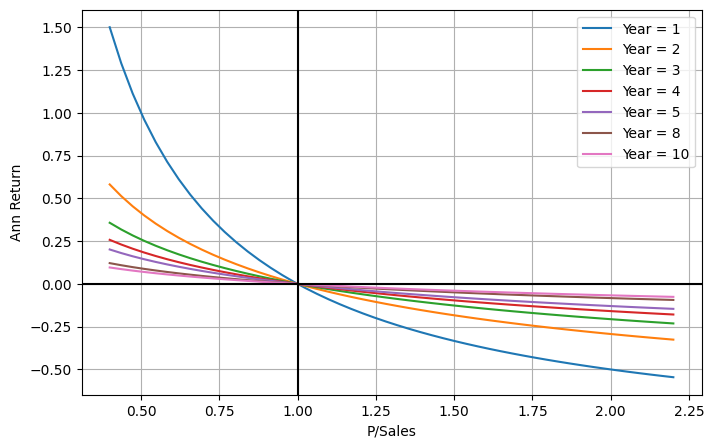

In [12]:
x = np.linspace(0.4, 2.2, 50)
a = 1
years = [1, 2, 3, 4, 5, 8, 10]

plt.figure(figsize=(8,5))
plt.rcParams['figure.dpi'] = 150

for y in years:
    plt.plot(x, a / x**(1/y) - 1, label=f'Year = {y}')

plt.axvline(x=1, color='black')
plt.axhline(y=0, color='black')
plt.legend()
plt.xlabel('P/Sales')
plt.ylabel('Ann Return')
plt.grid()
plt.show()

График получился вполне логичным, если понимать суть значения $\text{P/Sales}$. Если акция переоценена ($\text{P/Sales} > 5$), то среднегодовая доходность будет отрицательной(даже несмотря на то, что в будущем компания сможет вырваться вверх), но если акции наоборот недооценены($\text{P/Sales} < 1$), то мы скорее всего ожидаем прирост стоимости акции в связи с большим притоком денег в компанию

### Тестим!

Посмотрим как теория работает на практике. Но для начала немного считерим: передадим нашей модели все данные о будущем, чтобы проверить, что при правильных прогнозах трех параметров она будет выдавать результат, схожий с реальностью.

In [9]:
from data_loader2 import load_stock_data

ticker = 'PG'

df_PG = load_stock_data(ticker, dividend_TTM=True)


In [10]:
df_PG.dropna()

,Total Return,Share-price,Sales Per Share,P/Sales,Sales Growth,Earnings Per Share,P/E,Profit Margin,Book-Value Per Share,P/Book,Dividend TTM,P/Dividend,Dividend Yield
Date,,,,,,,,,,,,,
1994-06-30,5.120126,13.343750,11.070000,1.205397,-0.008065,0.810000,16.473765,0.073171,3.230000,4.131192,1.272088,10.489645,0.095332
1994-07-01,5.192069,13.531250,11.073014,1.222002,-0.007773,0.810411,16.696776,0.073188,3.231699,4.187040,1.272527,10.633366,0.094044
1994-07-02,5.192069,13.531250,11.076027,1.221670,-0.007481,0.810822,16.688313,0.073205,3.233397,4.184840,1.272967,10.629694,0.094076
1994-07-03,5.192069,13.531250,11.079041,1.221338,-0.007189,0.811233,16.679859,0.073222,3.235096,4.182643,1.273407,10.626025,0.094109
1994-07-04,5.192069,13.531250,11.082055,1.221006,-0.006897,0.811644,16.671414,0.073239,3.236795,4.180448,1.273846,10.622358,0.094141
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,114.507416,115.230003,28.513607,4.041229,0.055080,5.199781,22.160547,0.182361,18.851639,6.112466,3.058132,37.679867,0.026539
2020-06-27,115.312337,116.040003,28.517705,4.069051,0.055167,5.209836,22.273254,0.182688,18.851230,6.155567,3.058571,37.939282,0.026358
2020-06-28,116.117259,116.850004,28.521803,4.096866,0.055255,5.219891,22.385527,0.183014,18.850820,6.198670,3.059011,38.198622,0.026179


Договоримся о том, как будем оценивать качество наших предсказаний. Мы будем использовать 3 статистики:

- $\text{MAE}$ — средняя абсолютная ошибка.

$$
\text{MAE} = \frac{1}{n} \sum^n_{t=1}{|y_t - x_t|}
$$

- $\text{MSE}$ — средняя квадратичная ошибка.

$$
\text{MSE} = \frac{1}{n} \sum^n_{t=1}{(y_t - x_t)^2}
$$

- $R^2$ — коэффициент детерминации

    $$
    R^2 = 1 - \frac{\text{SSE}}{\text{SST}} = \dfrac{\sum^n_{t=1}(y_t - x_t)^2}{\sum^n_{t=1}(y_t - \bar{y})^2}
    $$

    Чем ближе значение к 1, тем лучше модель предсказала данные. Действительно, если наша модель предсказывает значения лучше, чем простое среднее(То есть её MSE меньше чем MSE для среднего), то $R^2 > 0$ растет, а если наоборот результаты хуже, то соответственно $R^2 < 0$ уменьшается. 

    <img src="./imgs/r2_explanation.png" alt="R2 explanation" width="600"/>

Теперь выведем следующую гипотезу: $H_0$ — наша модель предсказывает хуже исторического среднего, $H_1$ — наша модель предсказывает значения лучше исторического среднего. Для проверки воспользуемся критерием Стюдента для зависимых выборок `ttest_rel`:

$$
\delta(\overrightarrow{\text{Model Error}}, \overrightarrow{\text{Baseline Error}}) =
\begin{cases}
H_0: \mu_{\text{Model Error}} \ge \mu_{\text{Baseline Error}} \\
H_1: \mu_{\text{Model Error}} < \mu_{\text{Baseline Error}}
\end{cases}
$$

Если $\text{p-value}$ будет мало, то это будет свидетельствовать о том, что наши данные при предположении об истинности нулевой гипотезы маловероятны, а значит гипотезу $H_0$ придётся отвергнуть.

	Forecast	Baseline	p-value
MAE:	18.3%		14.8%		1.00e+00
MSE:	6.37e-02	4.02e-02	1.00e+00
R^2:	-0.58


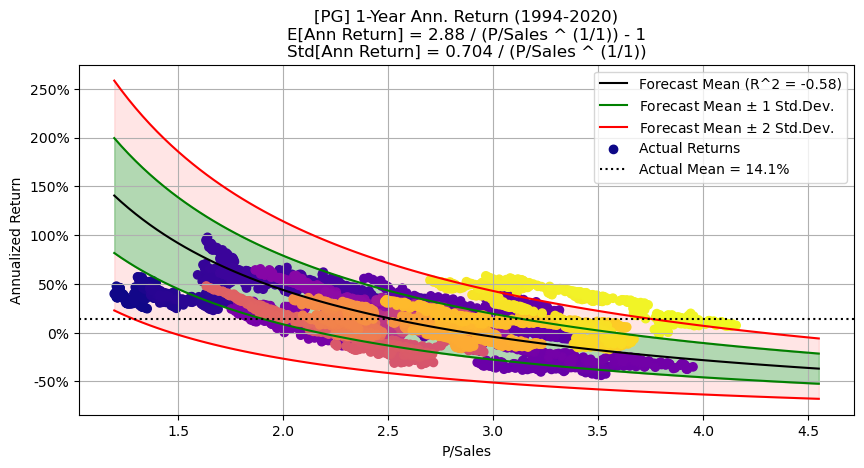

In [11]:
from plot_drawer2 import plot_ann_returns

plot = plot_ann_returns(years=1, ticker=ticker, df=df_PG, print_stats=True)

Раскрашенные точки показывают исторические значения годовой доходности при определённом значении мультипликатора 

	Forecast	Baseline	p-value
MAE:	3.1%		4.3%		7.56e-199
MSE:	1.48e-03	3.83e-03	5.63e-119
R^2:	0.61


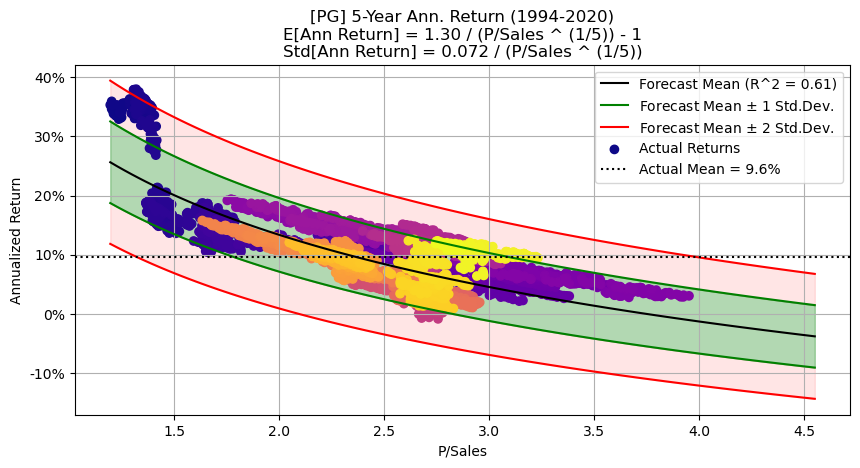

In [12]:
plot = plot_ann_returns(years=5, ticker=ticker, df=df_PG, print_stats=True)

	Forecast	Baseline	p-value
MAE:	1.7%		3.0%		0.00e+00
MSE:	4.10e-04	1.52e-03	7.70e-276
R^2:	0.73


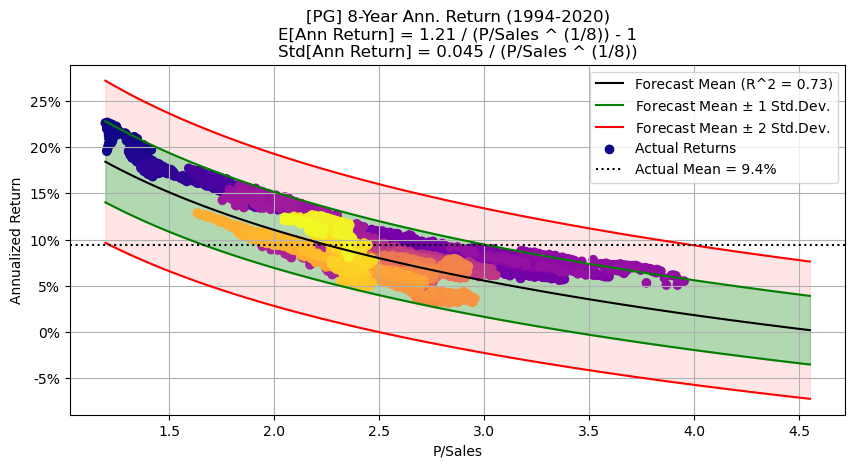

In [13]:
plot = plot_ann_returns(years=8, ticker=ticker, df=df_PG, print_stats=True)

Как мы видим, в модели, охватывающей год, ошибки очень большие и даже хуже среднего. Он вышел слишком зашумленным и случайным
Но ситуация меняется при рассмотрении в промежутке 5-ти лет, и ещё сильнее - 8-ми лет. Ошибки уже заметно меньше(при рассмотрении 8-ми летнего случая мы попали в границы одного Std), а R растёт. То есть характеристика $\text{P/Sales}$ очень хорошо справляется в более долгосрочном рассмотрении. Однако, это не всегда так.

	Forecast	Baseline	p-value
MAE:	58.0%		27.8%		1.00e+00
MSE:	4.36e-01	1.37e-01	1.00e+00
R^2:	-2.18


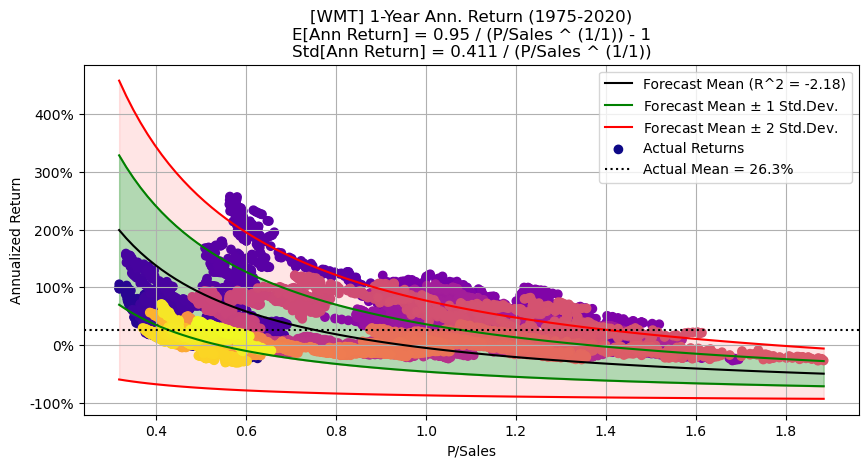

In [14]:
ticker = 'WMT'

df_PG = load_stock_data(ticker, dividend_TTM=True)

plot = plot_ann_returns(years=1, ticker=ticker, df=df_PG, print_stats=True)

	Forecast	Baseline	p-value
MAE:	17.4%		18.8%		4.92e-65
MSE:	4.12e-02	4.65e-02	3.03e-55
R^2:	0.11


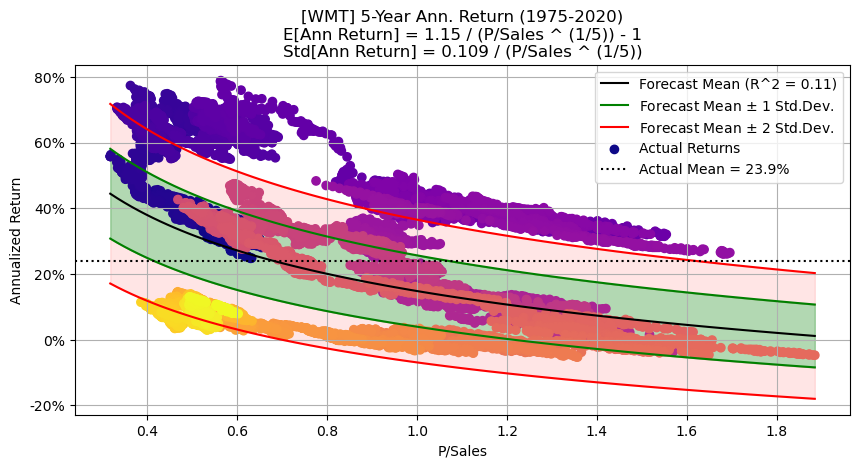

In [15]:
plot = plot_ann_returns(years=5, ticker=ticker, df=df_PG, print_stats=True)

	Forecast	Baseline	p-value
MAE:	14.8%		15.5%		4.52e-45
MSE:	2.95e-02	3.54e-02	2.64e-187
R^2:	0.17


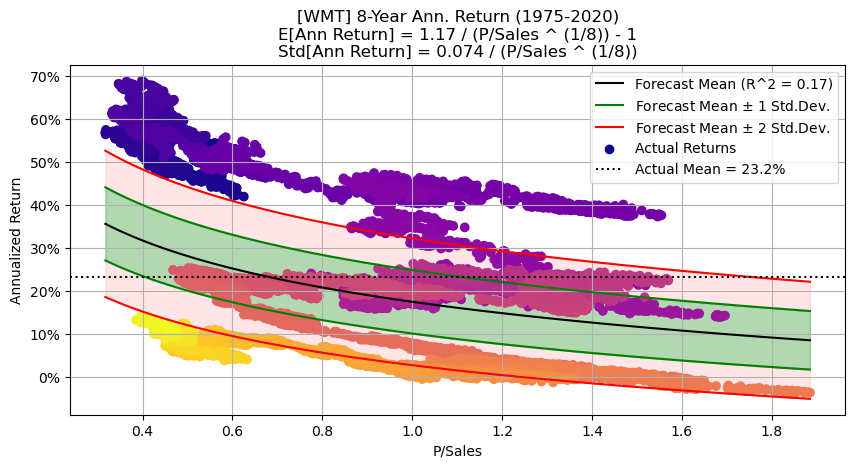

In [16]:
plot = plot_ann_returns(years=8, ticker=ticker, df=df_PG, print_stats=True)

Также, как и в первом случае, в промежутке в год всё достаточно плохо - отрицательный R и большие ошибки. Но, в отличие от первого случая, в промежутках на 5 и 8 лет ситуация сильно не улучшается - ошибка действительно становится меньше, R растёт, но прогноз всё равно очень слабый.

На самом деле, этот алгоритм может неплохо работать и с пакетами акций, например, с S&P 500

![Для года](\SP500\one_year.png)

![Для 5-ти лет](\SP500\five_years.png)

![Для 10-ти лет](\SP500\ten_years.png)

## Выводы по работе

- Наша теоретическая модель подтвердилась - формула даёт характерные кривые, хорошо описывающие полученные данные, и показывает, что при высоких $\text{P/Sales}$ темпы роста акции действительно ниже.
- Обратная зависимость $\text{P/Sales}$ и доходности. На всех рассмотренных горизонтах (1, 5 и 10 лет) наблюдается чёткая отрицательная связь между мультипликатором цены к выручке ($\text{P/Sales}$) на момент покупки и последующей среднегодовой доходностью: чем ниже $\text{P/Sales}$, тем выше доходность.
- Усиление эффекта с ростом горизонта инвестирования. Корреляция между $\text{P/Sales}$ и доходностью становится сильнее по мере увеличения срока удержания акций. Для 5- и 10-летних периодов эффект более выражен, чем для однолетних. Также заметим, что можно рассмтаривать не только определённый момент (прогноз спустя год, спустя 3 года), но и прогноз на промежутке времени - например в период 2-4 года, 4-6 лет. Подробнее об этом можно почитать в Appendinx
- Использование $\text{P/Sales}$ как базового фундаментального критерия позволяет сконструировать портфель с повышенным долгосрочным потенциалом доходности без сложных моделей и машинного обучения.
- Несмотря на свою относительную простоту, всё же стоит и отметить, что на коротких промежутках времени он не так эффективен, а также может достаточно сильно ошибаться в случаях сильных колебаний  цен акций (Яркий пример тому - акции Walmart)


Источники и литература:
- [Pedersen, M. E. H. (2020). Long-Term Stock Forecasting. Hvass Labs.](https://raw.githubusercontent.com/Hvass-Labs/Finance-Papers/master/pedersen2020long-term_stock_forecasting.pdf)
- [Pedersen, M. E. H. (2021). Simple Portfolio Optimization That Works!](https://raw.githubusercontent.com/Hvass-Labs/Finance-Papers/master/pedersen2021simple-portfolio-optimization.pdf)
- [Серия статей, поясняющая работу рынка](https://habr.com/ru/articles/120842/)